# Imports

In [1]:
import os
import datetime
import warnings
warnings.filterwarnings("ignore")

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import numpy as np
from rpgpy import read_rpg
from scipy.ndimage import gaussian_filter

import Voodoo.Loader as Loader
import Voodoo.TorchModel as TM
import Voodoo.Utils as UT


# General settings

# RPG-FMCW94 LV0 input

In [2]:
data_path = 'example_data/RPG-FMCW94/'
file_name = '190801_060001_P05_ZEN.LV0'
cat_file_name = '20190801-punta-arenas-categorize-limrad94.nc'

file_name = '201230_160001_P05_ZEN.LV0'
cat_file_name = '20201230-LIM-categorize-limrad94.nc'

rpg_lv0_header, rpg_lv0_data = read_rpg(data_path + file_name)

### Convert UNIX time to numpy.datetime64

In [3]:
# time since 2001-01-01 to UNIX to numpy.datetime64
ts_list = rpg_lv0_data['Time'] + UT.dt_to_ts(datetime.datetime(2001, 1, 1))
dt_list = [UT.ts_to_dt(ts) for ts in ts_list]
np_dt_list = np.array([np.datetime64(ts,'s') for ts in dt_list])
t0_radar, t1_radar = np_dt_list[0], np_dt_list[-1]


### Load Cloudnet Categorization

In [4]:
# input categorize data
# slice clounet categorize file 
# convert Cloudnet time step to UNIX time
cn_data = Loader.open_xarray_datasets(data_path + cat_file_name)
cn_data = cn_data.sel(time=slice(t0_radar, t1_radar))
ts_main = [UT.get_unixtime(ts.values) for ts in cn_data['time']]


### Preprocessor

In [43]:
# replace fill values
nonzeros_spectra = rpg_lv0_data['TotSpec'] > 0.0
rpg_spectra_vh = Loader.replace_fill_value(rpg_lv0_data['TotSpec'], rpg_lv0_data['SLv'])
rpg_spectra_h = Loader.replace_fill_value(rpg_lv0_data['HSpec'], rpg_lv0_data['SLh'])


# preprocess spectra, create time-spectrograms
interp_var, interp_mask = Loader.hyperspectralimage(
    ts_list, # radar time resolution
    rpg_spectra_vh, # vertica+horizontal spectra
    rpg_spectra_h, # horizontal spectra
    nonzeros_spectra, # nonzero mask of spectra
    6, # number of time steps used for time spectrogram
    ts_main # target time resolution
)

nonzeros_mask = (interp_mask.any(axis=3)).any(axis=2)

### Reshape to list of samples

In [44]:
# create feature list
spectra_list = []
for ind_t in range(nonzeros_mask.shape[0]):
    for ind_h in range(nonzeros_mask.shape[1]):
        if nonzeros_mask[ind_t, ind_h]:
            spectra_list.append(interp_var[ind_t, ind_h, :, :, 0])
            
spectra_list = np.array(spectra_list)
spectra_list = UT.lin2z(spectra_list) 

### Normalize feautres

In [45]:
# normalize features between 0 and 1
Z_min, Z_max = -50, 20
X = (spectra_list - Z_min) / (Z_max - Z_min)
X[X<0] = 0
X[X>1] = 1

# Prediction

In [46]:
# inference mode
prediction = Loader.VoodooPredictor(X)

# Postprocessing

In [47]:
# reshape from list of samples to spatio-temporal domain and
# smooth predictions with Gaussian filter on the spatio-temporal grid
tmp = TM.VoodooNet.reshape(prediction[:, 1], ~nonzeros_mask) # 2nd dimension needs to be 1 !
tmp = gaussian_filter(tmp, sigma=1)

### Add predictions to xarray data set

In [48]:
# add new data array to data set
cn_data['voodoo'] = cn_data['v'].copy()
cn_data['voodoo'].attrs.update({
    'units': '1', 
    'long_name': 'probability for cloud droplets', 
    'comment': 'Voodoo retrieval output'
})
cn_data['voodoo'].values = tmp

# Plotting 

probability for CD = 0.984


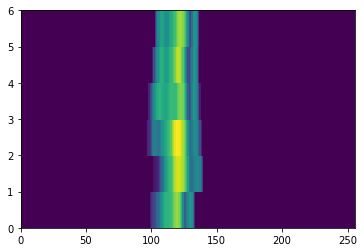

In [49]:
# plot example spectrum
ind = int(prediction[:, 1].argmax())
plt.pcolormesh(X[ind].T)
print(f'probability for CD = {prediction[ind, 1]:.3f}')

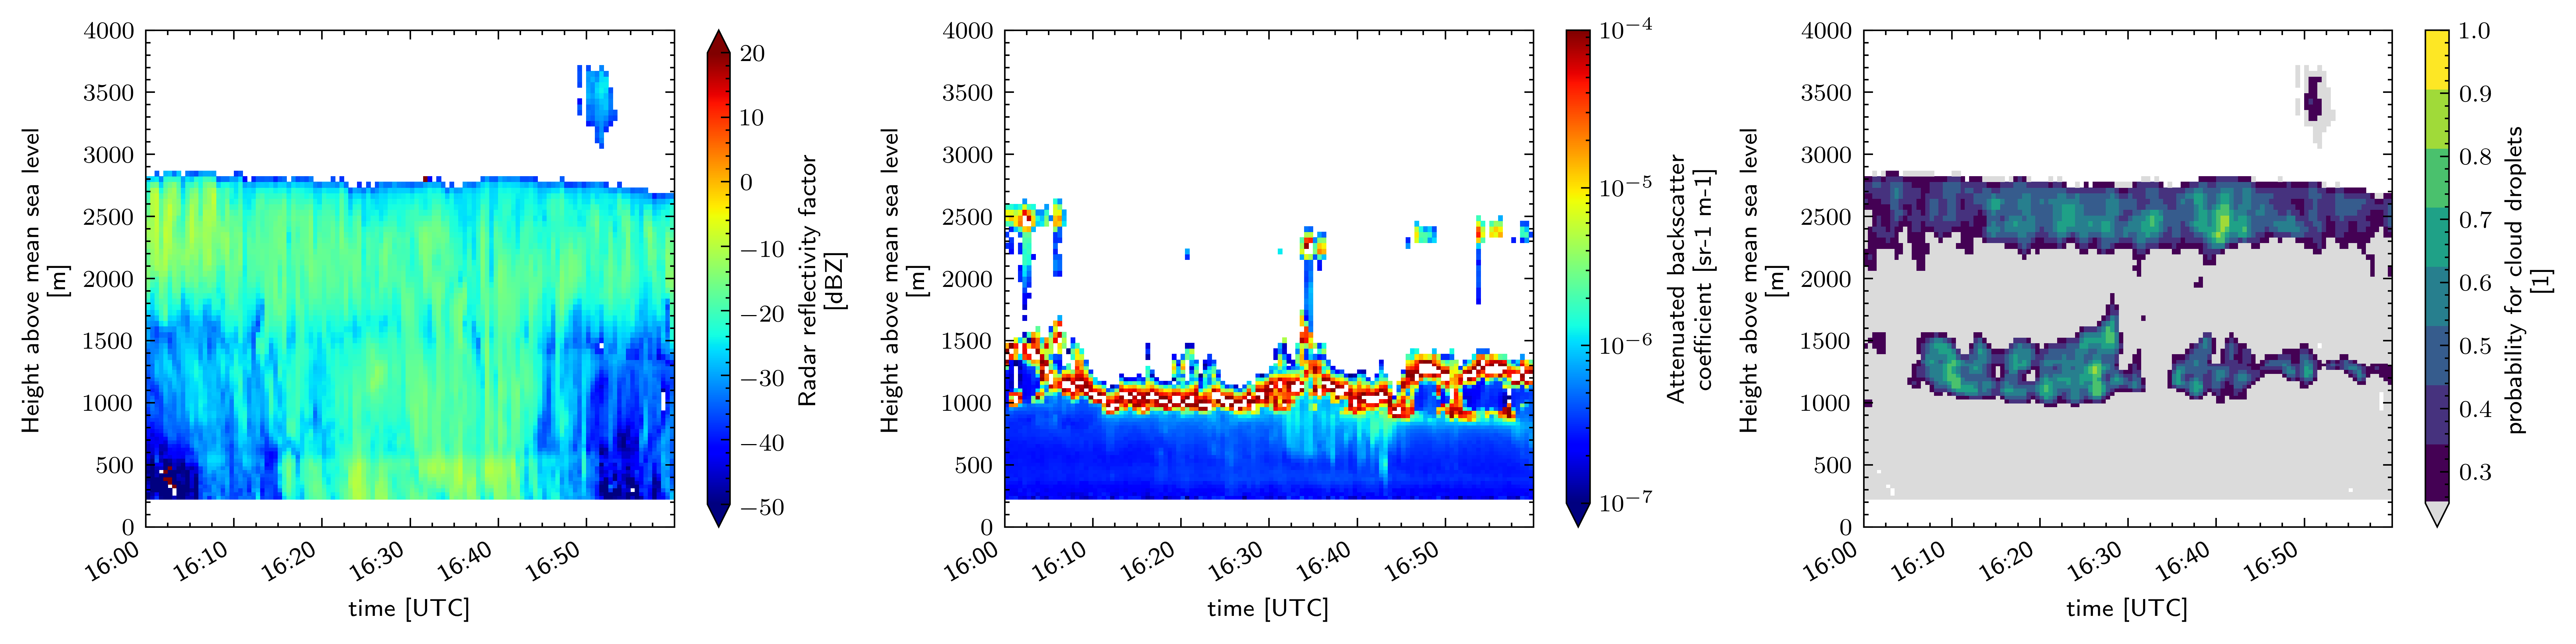

In [50]:
# quicklook Ze, beta, P(CD)
p=0.25

with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots(ncols=3, figsize=(14,3))

    cn_data['Z'].values = np.ma.masked_where(~nonzeros_mask, cn_data['Z'].values)
    cn_data['Z'].T.plot(vmin=Z_min, vmax=Z_max, cmap='jet', ax=ax[0])
    
    cn_data['beta'].values = np.ma.masked_where(cn_data['beta']>1.0e-4, cn_data['beta'].values)
    cn_data['beta'].T.plot(norm = LogNorm(vmin=1.0e-7, vmax=1.0e-4), cmap='jet', ax=ax[1])
    
    cn_data['voodoo'].values = np.ma.masked_where(~nonzeros_mask, cn_data['voodoo'].values)
    cn_data['voodoo'].T.plot(vmin=p, vmax=1, cmap=UT.probability_cmap, ax=ax[2])
    
    for iax in ax:
        iax.set_ylim((0,4000))
        iax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    fig.subplots_adjust(wspace=0.3)